In [1]:
import os
import warnings
import joblib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed 
from sklearn import ensemble, linear_model, svm
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV

from success_utils import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create a dictionary to group countries by region
region_groups = {
    "North America": ["HI", "Mexico", "NV", "OK", "NM","CA", "NY", "MD", "DC", "WA", "CO", "MN", "TX", "SC", "GA", "KY", "PA", "MI", "OH", "OR", "NC", "IL", "AZ", "TN", "NJ", "UT", "VA", "ND", "VT", "IA", "ND", "VT", "LA", "CT", "RI"],
    "Europe": ["Martinique", "AL", "Cayman Islands", "Russia", "ME", "UK", "DE", "Poland", "Denmark", "Netherlands", "Norway", "Liechtenstein", "Austria", "Belgium", "Czech Republic", "Iceland", "Ireland", "France", "Spain", "Sweden", "Switzerland", "Italy", "Slovenia", "Greece"],
    "Asia": ["MO", "IN", "Japan", "China", "Hong Kong", "India", "Viet Nam", "Taiwan", "Afghanistan", "Israel","Sri Lanka", "Jordan"],
    "South America": ["Colombia", "Brazil"],
    "Africa": ["WI", "SD", "MA", "Ghana", "Ethiopia", "Liberia", "Rwanda"],
    "Oceania": ["AU", "NZ"],
    "Other": [ "United Arab Emirates", "Svalbard and Jan Mayen"]
}

noticable_entities = ['ORG', 'PERSON', 'DATE',
                        'CARDINAL', 'GPE', 'PRODUCT', 
                        'WORK_OF_ART','ORDINAL', 'MONEY',
                        'TIME', 'NORP']


data_path = '/workspaces/Crowdfunding-Social-Media-Drivers/Data/Kickstarter_only/final_data.csv'
success_data = pd.read_csv(data_path)
success_data['collection_ratio'] = success_data.collected.apply(decode_amount)/success_data.goal_amount.apply(decode_amount)


bins = [0, 7, 14, 30, 60]
labels = ['<1 week', '1-2 weeks', '2 weeks - 1 month', '1-2 months']
success_data['duration'] = pd.cut(success_data['duration'], bins=bins, labels=labels)
success_data= success_data[success_data.donate != 1].reset_index(drop=True)


success_weights = (1-success_data.success.value_counts()/len(success_data)).values


def get_region(country):
    for region, countries in region_groups.items():
        if country in countries:
            return region
    return "Other"

success_data['region'] = success_data.country.str.strip().apply(get_region)
success_data.num_backers = success_data.num_backers.str.replace(',', '').astype(int)

success_data = pd.get_dummies(
                    success_data,
                    columns=['category',
                              'fb_type',
                              'region', 
                              'duration'])


for entity in noticable_entities:
    success_data[f'fb_entity_{entity}'] = success_data.fb_entities_identified.fillna('None').str.split(',').apply(lambda entity_list: entity in entity_list).astype(int)
    

bool_cols = success_data.dtypes[success_data.dtypes == 'bool'].index.tolist()
success_data[bool_cols] = success_data[bool_cols].astype(int)

#ecoding the number of backers
success_data.num_backers = encode_targets(success_data.num_backers)
success_data.population = np.exp(success_data.population)

features_to_scale = ['population', 'num_projects', 'num_backed']
scaler = MinMaxScaler()
scaler.fit(success_data[features_to_scale])
scaled_features = scaler.transform(success_data[features_to_scale])
success_data[features_to_scale] = scaled_features

success_data.head()



,collected,goal_amount,num_backers,pledge_types,donate,project_we_love,success,start_month,start_day,population,country,Person,Team,num_projects,num_backed,verified,fb_page_name,fb_likes_at_posting,fb_followers_at_posting,fb_likes,fb_comments,fb_shares,fb_post_views,fb_entities_identified,fb_post_sponsored,fb_post_age,fb_page_age,fb_positive_reactions,fb_negative_reactions,fb_topic_0,fb_topic_1,fb_topic_2,fb_topic_3,fb_topic_4,fb_topic_5,fb_topic_6,fb_topic_7,fb_topic_8,fb_topic_9,fb_topic_10,collection_ratio,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film_Video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,fb_type_link,fb_type_photo,fb_type_video,region_Africa,region_Asia,region_Europe,region_North America,region_Oceania,region_Other,region_South America,duration_<1 week,duration_1-2 weeks,duration_2 weeks - 1 month,duration_1-2 months,fb_entity_ORG,fb_entity_PERSON,fb_entity_DATE,fb_entity_CARDINAL,fb_entity_GPE,fb_entity_PRODUCT,fb_entity_WORK_OF_ART,fb_entity_ORDINAL,fb_entity_MONEY,fb_entity_TIME,fb_entity_NORP
0,8.60,8.50,4.20,7.00,0.00,1.00,1,6,4,0.01,MA,1,0,0.02,0.01,janos stone,Kickstarter,1589842,1587991,1,1,0,2,"ORG,PERSON,DATE",0,0,4839,1,0,0.00,0.20,0.00,0.19,0.00,0.00,0.00,0.40,0.00,0.00,0.18,1.11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0
1,11.63,10.89,7.29,9.00,0.00,1.00,1,7,1,0.37,Japan,0,1,0.02,0.00,Maho Williams,Kickstarter,1589866,1588006,5,2,0,5,NaN,0,2,4839,0,0,0.00,0.17,0.00,0.00,0.78,0.00,0.00,0.00,0.00,0.00,0.00,2.10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,12.96,10.82,6.82,4.00,0.00,1.00,1,6,1,0.03,WA,0,1,0.09,0.02,Marc Barros,Kickstarter,1589901,1588019,10,2,1,12,PRODUCT,0,2,4839,2,0,0.00,0.00,0.29,0.12,0.00,0.00,0.55,0.00,0.00,0.00,0.00,8.51,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,9.03,11.02,4.54,12.00,0.00,1.00,0,6,6,0.34,UK,1,0,0.02,0.00,Akwasi Brenya-Mensa,Kickstarter,1590070,1588169,7,2,0,9,"FAC,NORP,PERSON,GPE",0,7,4839,0,2,0.00,0.00,0.37,0.00,0.00,0.00,0.00,0.20,0.00,0.37,0.00,0.14,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
4,11.87,9.90,6.95,8.00,0.00,1.00,1,6,1,0.00,CA,1,0,0.03,0.13,Adam Lawson,Kickstarter,1589930,1588019,4,1,0,5,"CARDINAL,PERSON",0,8,4839,0,1,0.00,0.00,0.94,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0


In [2]:
dropping_columns = ['collected', 'verified', 'goal_amount', 'donate', 'project_we_love', 'country', 'fb_page_name', 'fb_entities_identified']

success_data.drop(columns=dropping_columns, axis=1, inplace=True)
success_data = success_data[success_data.collection_ratio < 10].reset_index(drop=True)
success_data.pledge_types = success_data.pledge_types.astype(int)
success_data.num_projects = success_data.num_projects.astype(int)
success_data.num_backed = success_data.num_backed.astype(int)


In [3]:
target_cols = [
    'success',
    'collection_ratio',
    'num_backers'
]

fb_cols = success_data.columns[success_data.columns.str.startswith('fb')].tolist()
common_features= success_data.columns[~success_data.columns.str.startswith('fb')].tolist()
common_features = [feature for feature in common_features if feature not in target_cols]

engagement_features = [ 'fb_likes', 'fb_comments', 'fb_shares','fb_positive_reactions','fb_negative_reactions']
post_fb_features = [feature for feature in fb_cols if feature not in engagement_features]


In [4]:
domain_page_features = success_data[common_features]
domain_engagement_features = success_data[common_features + engagement_features]
domain_post_features = success_data[common_features + post_fb_features]

targets = success_data[target_cols]

In [5]:
print(common_features)

['pledge_types', 'start_month', 'start_day', 'population', 'Person', 'Team', 'num_projects', 'num_backed', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film_Video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'region_Africa', 'region_Asia', 'region_Europe', 'region_North America', 'region_Oceania', 'region_Other', 'region_South America', 'duration_<1 week', 'duration_1-2 weeks', 'duration_2 weeks - 1 month', 'duration_1-2 months']


## Modelling

In [5]:
domain_post = pd.read_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_post.csv')

In [6]:
domain_post.loc[:,target_cols].head()

,success,collection_ratio,num_backers
0,1,1.11,4.20
1,1,2.10,7.29
2,1,8.51,6.82
3,0,0.14,4.54
4,1,7.12,6.95


In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(domain_post.drop(target_cols, axis=1), domain_post[target_cols], test_size=0.2, random_state=42, stratify=domain_post.success)

# Load the scaler
scaler = MinMaxScaler()
#load from scaler.pkl
# scaler = joblib.load('./02_success_engagement/domain_engagement_scaler.pkl')
# scaler = joblib.load('./02_success_engagement/domain_post_scaler.pkl')


# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, './02_success_engagement/domain_post_scaler_success.pkl')

['./02_success_engagement/domain_post_scaler_success.pkl']

In [96]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'], 
    
}

# Create the SVM model
svm_model = SVR()



# Fit the grid search to the data
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_scaled, y_train.iloc[:,1])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}, -0.030537433633852085)

In [97]:
param_grid = {
    'kernel': ['poly', 'rbf'],
    'gamma': ['scale'],
    'C': [10, 100, 1000],
    'degree': [1,2,3,4,5,6,7,8,9,10]
}

# Create the SVM model
svm_model = SVR()

# Fit the grid search to the data
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_scaled, y_train.iloc[:,1])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

({'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'},
 -0.018049146145677587)

In [29]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear'],
}

# Create the SVM model
svm_model = SVR()

# Fit the grid search to the data
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_scaled, y_train.iloc[:,1])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


({'C': 100, 'kernel': 'linear'}, -0.012309475326919016)

## importances


In [19]:
domain_post = pd.read_csv('/workspaces/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_post.csv')

X_train, X_test, y_train, y_test = train_test_split(domain_post.drop(target_cols, axis=1), domain_post[target_cols], 
                                                    test_size=0.2, random_state=42, stratify=domain_post.success)

# Load the scaler
scaler = MinMaxScaler()
#load from scaler.pkl
# scaler = joblib.load('./02_success_engagement/domain_engagement_scaler.pkl')
scaler = joblib.load('./02_success_engagement/domain_post_scaler.pkl')


# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load the model
model = joblib.load('/workspaces/Crowdfunding-Social-Media-Drivers/Modelling/02_success_engagement/domain_post_num_backers.pkl')


In [14]:
y_test.head()

,success,collection_ratio,num_backers
774,1,1.43,6.51
428,1,1.14,6.49
706,1,1.30,5.30
297,0,0.71,6.05
715,1,1.04,5.99


,Importance
pledge_types,0.16
fb_post_views,0.13
category_games,0.11
fb_topic_2,0.08
fb_topic_1,0.06
fb_topic_7,0.05
fb_topic_6,0.04
fb_topic_8,0.04
fb_topic_9,0.04
fb_topic_5,0.04


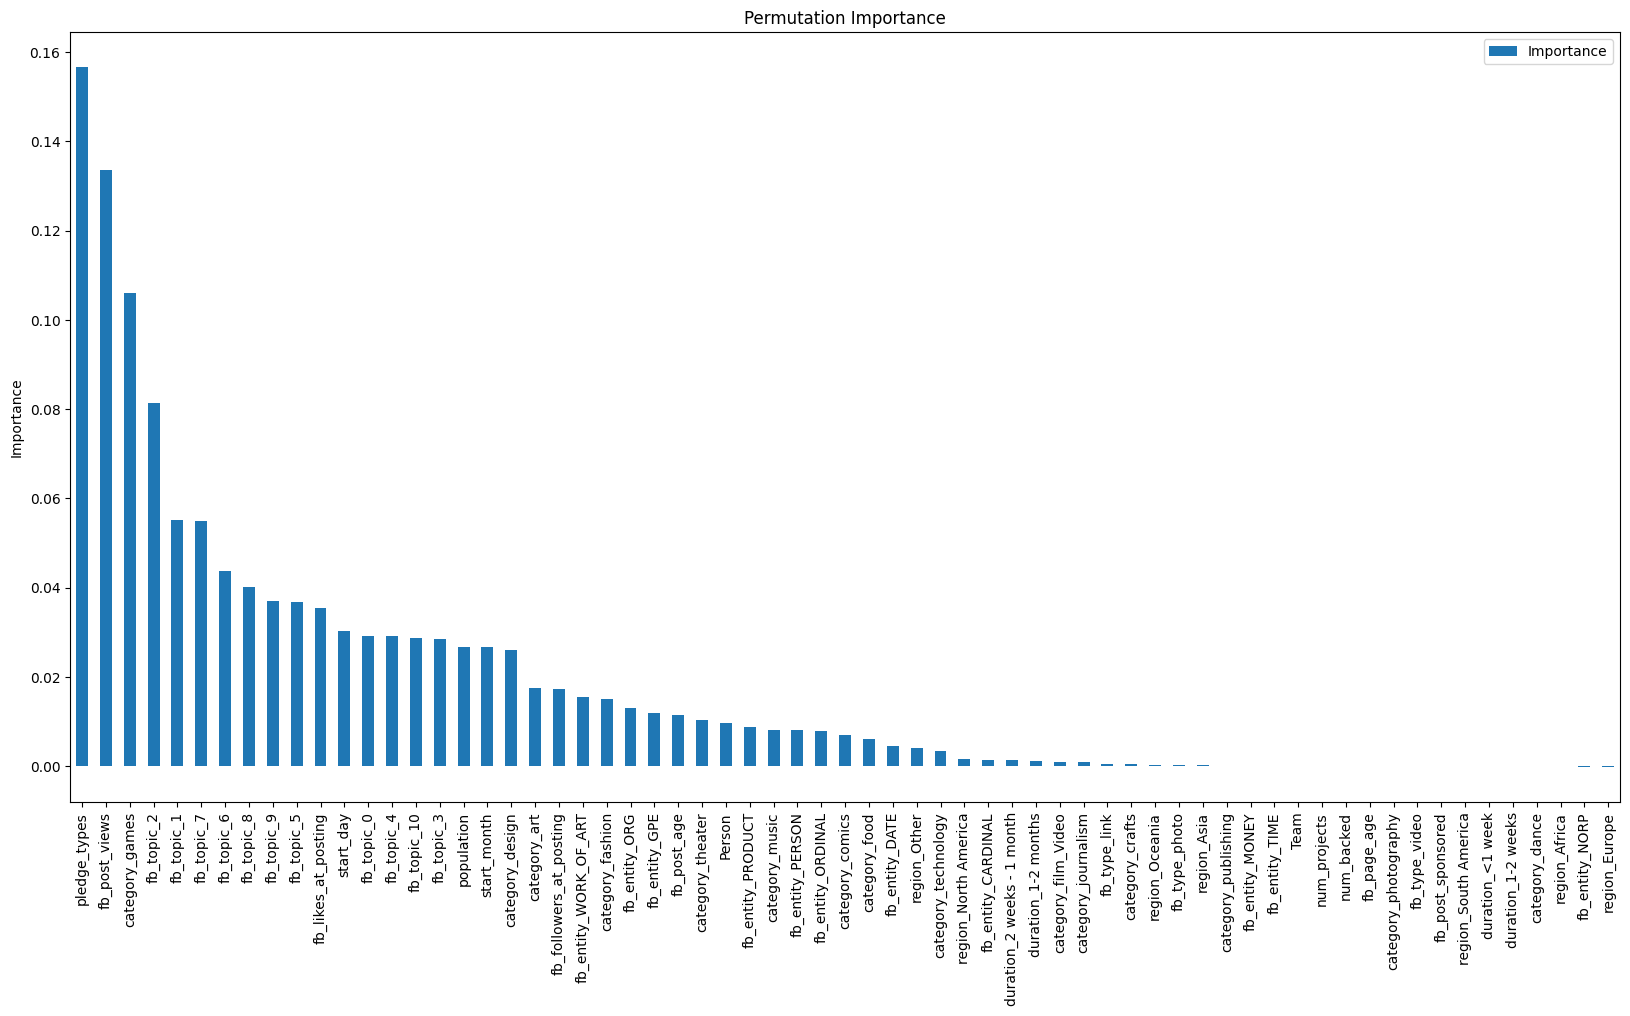

In [21]:
plot_permutation_importance(model, X_test_scaled, y_test.iloc[:,2], imp_columns=X_test.columns)